In [15]:
import cv2
import mediapipe as mp
from matplotlib import pyplot as plt
from PIL import Image

In [16]:
# GLOBAL SETTINGS
mp_drawing = mp.solutions.drawing_utils
mp_face_mesh = mp.solutions.face_mesh
VISUALIZATION = False

# HELPER fUNCTIONS
def process_input(img_path, img_format='pil_image'):
    if img_format == 'pil_image':
        img = Image.open(img_path)

    if img_format == 'cv2':
        img = cv2.imread(img_path)

    return img


def display_image(face_mesh_result, img_path):
    plt.imshow(process_input(img_path), zorder=1)
    x, y = face_mesh_result[:, 0], face_mesh_result[:, 1]
    plt.scatter(x, y, zorder=2, s=1.0)
    plt.show()


def process_landmark_points(annotations_or, image):

    landmark_points_org = np.array([
        (int((i.x) * image.shape[1]), int(i.y * image.shape[0]))
        for i in annotations_or.multi_face_landmarks[0].landmark
    ])

    landmark_points_org = [list(map(int, i)) for i in landmark_points_org]
    landmark_points_tuple = [tuple(i) for i in landmark_points_org]
    landmark_points_arr = np.array(landmark_points_tuple, np.int32)

    return landmark_points_tuple, landmark_points_arr


def rect_around_triangle(points_list):
    triangle = np.array(points_list, np.int32)
    rect = cv2.boundingRect(triangle)
    return rect

./images/baburao.jpg


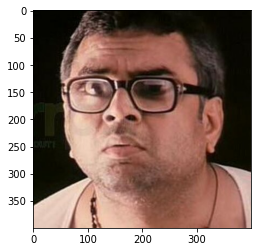

In [17]:
source_path = './images/baburao.jpg'
file_list = [source_path]
images = {i: cv2.cvtColor(cv2.imread(i), cv2.COLOR_BGR2RGB) for i in file_list}

# original image , gray image, and mask
source_img = process_input(source_path,img_format='cv2')
source_img_gray = cv2.cvtColor(source_img, cv2.COLOR_BGR2GRAY)
source_img_mask = np.zeros_like(source_img_gray)

# Preview the images.
for name, image in images.items():
    print(name)
    plt.show()
    plt.imshow(image)

In [18]:
mp_face_mesh = mp.solutions.face_mesh
# help(mp_face_mesh.FaceMesh)

# Initialize MediaPipe Face Mesh.
face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=2,
    min_detection_confidence=0.5)

# Prepare DrawingSpec for drawing the face landmarks later.
mp_drawing = mp.solutions.drawing_utils 
drawing_spec = mp_drawing.DrawingSpec(thickness=2, circle_radius=1,color = (0,0,255))

In [19]:
annotaions_org_images = []
for name, image in images.items():
    # Convert the BGR image to RGB and process it with MediaPipe Face Mesh.
    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Draw face landmarks of each face.
    print(f'Face landmarks of {name}:')
    if not results.multi_face_landmarks:
        continue
    annotaions_org_images.append(results)
    annotated_image = image.copy()
    for face_landmarks in results.multi_face_landmarks:
        mp_drawing.draw_landmarks(image=annotated_image,
                                  landmark_list=face_landmarks,
                                  connections=mp_face_mesh.FACE_CONNECTIONS,
                                  landmark_drawing_spec=drawing_spec,
                                  connection_drawing_spec=drawing_spec)
    if VISUALIZATION:
        plt.show()
        plt.imshow(annotated_image)

Face landmarks of ./images/baburao.jpg:


In [20]:
face_mesh = mp_face_mesh.FaceMesh(min_detection_confidence=0.5,min_tracking_confidence=0.5)
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)
cap = cv2.VideoCapture(0)
while cap.isOpened():
    try:
        success, image = cap.read()
        if not success:
            break
        # Flip the image horizontally for a later selfie-view display, and convert
        # the BGR image to RGB.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.rotate(image, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
        # To improve performance, optionally mark the image as not writeable to
        # pass by reference.
        image.flags.writeable = False
        results = face_mesh.process(image)
        if not results.multi_face_landmarks:
            continue

        # Draw the face mesh annotations on the image.
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        ################################# Face Swap #################################
        target_img = image  ## change later
        target_img_gray = cv2.cvtColor(target_img, cv2.COLOR_BGR2GRAY)
        source_landmark_points_tuple, source_landmark_points_arr = process_landmark_points(
            annotaions_org_images[0], source_img)
        target_landmark_points_tuple, target_landmark_points_arr = process_landmark_points(
            results, target_img)

        source_convex_hul = cv2.convexHull(source_landmark_points_arr)
        target_convex_hul = cv2.convexHull(target_landmark_points_arr)

        # Delaunav Triangulation for source face
        rect = cv2.boundingRect(
            source_convex_hul
        )  # returns rectangle sourrouding the convexhull (x,y,w,h)
        subdiv = cv2.Subdiv2D(
            rect
        )  # this is a builtin function in opencv to find Delaunav triangulation
        subdiv.insert(source_landmark_points_tuple)  # insert the points as tuple
        triangles_source_face = subdiv.getTriangleList(
        )  # returns the triangle from image (3 point of x,y)
        triangles_source_face = np.array(triangles_source_face, dtype=np.int32)

        #get the corresponding index from the landmark_points_arr
        #this index will be used to get the values from the target_face

        triangles_source_face_index = []
        for t in triangles_source_face:
            pt1 = (t[0], t[1])
            pt1_index = np.where((source_landmark_points_arr == pt1).all(axis=1))[0][0]
            pt2 = (t[2], t[3])
            pt2_index = np.where((source_landmark_points_arr == pt2).all(axis=1))[0][0]
            pt3 = (t[4], t[5])
            pt3_index = np.where((source_landmark_points_arr == pt3).all(axis=1))[0][0]
            triangles_source_face_index.append([pt1_index, pt2_index, pt3_index])

        # Triangulation 
        new_target_face = np.zeros_like(target_img) 

        for triangle_index in triangles_source_face_index:

            ################ Triangulation Source Face ################
            # get triangle index
            tr1_pt1 = tuple(source_landmark_points_arr[triangle_index[0]])
            tr1_pt2 = tuple(source_landmark_points_arr[triangle_index[1]])
            tr1_pt3 = tuple(source_landmark_points_arr[triangle_index[2]])

            # get rect around triangle
            (x, y, w, h) = rect_around_triangle([tr1_pt1, tr1_pt2, tr1_pt3])
            cropped_triangle_source = source_img[y:y + h, x:x + w]
            # create a mask same size of rect
            cropped_triangle1_mask = np.zeros((h, w), np.uint8)
            points1 = np.array(
                [[tr1_pt1[0] - x, tr1_pt1[1] - y], [tr1_pt2[0] - x, tr1_pt2[1] - y],
                 [tr1_pt3[0] - x, tr1_pt3[1] - y]], np.int32)
            cv2.fillConvexPoly(cropped_triangle1_mask, points1, 255)
            # this filters out the triangular part of the image using the mask
            ## TODO: this line below was making output have black joining lines for the triangles, not sure why
            # cropped_triangle_source = cv2.bitwise_and(cropped_triangle_source,cropped_triangle_source,mask=cropped_triangle1_mask)

            ################ Triangulation Target Face ################
            tr2_pt1 = tuple(target_landmark_points_arr[triangle_index[0]])
            tr2_pt2 = tuple(target_landmark_points_arr[triangle_index[1]])
            tr2_pt3 = tuple(target_landmark_points_arr[triangle_index[2]])

            # get rect around triangle
            (x, y, w, h) = rect_around_triangle([tr2_pt1, tr2_pt2, tr2_pt3])
            cropped_triangle_target = target_img[y:y + h, x:x + w]
            # create a mask same size of rect
            cropped_triangle2_mask = np.zeros((h, w), np.uint8)
            points2 = np.array(
                [[tr2_pt1[0] - x, tr2_pt1[1] - y], [tr2_pt2[0] - x, tr2_pt2[1] - y],
                 [tr2_pt3[0] - x, tr2_pt3[1] - y]], np.int32)
            cv2.fillConvexPoly(cropped_triangle2_mask, points2, 255)
            # this filters out the triangular part of the image using the mask
            # cropped_triangle_target = cv2.bitwise_and(cropped_triangle_target,cropped_triangle_target,mask=cropped_triangle2_mask)
            # warped using affine transform
            points1 = points1.astype(np.float32)
            points2 = points2.astype(np.float32)
            M = cv2.getAffineTransform(points1, points2)
            warped_triangle = cv2.warpAffine(cropped_triangle_source, M, (w, h))
            warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=cropped_triangle2_mask)

            # Reconstructing destination face
            new_target_face_rect_area = new_target_face[y: y + h, x: x + w]
            new_target_face_rect_area_gray = cv2.cvtColor(new_target_face_rect_area, cv2.COLOR_BGR2GRAY)

            # Let's create a mask to remove the lines between the triangles
            _, mask_triangles_designed = cv2.threshold(new_target_face_rect_area_gray, 1, 255, cv2.THRESH_BINARY_INV)
            warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=mask_triangles_designed)
            img2_new_face_rect_area = cv2.add(new_target_face_rect_area, warped_triangle)
            new_target_face[y: y + h, x: x + w] = img2_new_face_rect_area

        # Face swapped (putting 1st face into 2nd face)
        img2_face_mask = np.zeros_like(target_img_gray)
        img2_head_mask = cv2.fillConvexPoly(img2_face_mask, target_convex_hul, 255)
        img2_face_mask = cv2.bitwise_not(img2_head_mask)
        img2_head_noface = cv2.bitwise_and(target_img, target_img, mask=img2_face_mask)
        result = cv2.add(img2_head_noface, new_target_face)

        (x, y, w, h) = cv2.boundingRect(target_convex_hul)
        center_face2 = (int((x + x + w) / 2), int((y + y + h) / 2))
        seamlessclone = cv2.seamlessClone(result, target_img, img2_head_mask, center_face2, cv2.NORMAL_CLONE)
        median = cv2.medianBlur(seamlessclone,3)

        ##################################################################
        cv2.imshow('MediaPipe seamlessclone', seamlessclone)
        cv2.imshow('MediaPipe result', result)
        cv2.imshow('MediaPipe median', median)
        if cv2.waitKey(5) & 0xFF == ord('q'):
            break
    except Exception as e:
        continue
face_mesh.close()
cap.release()
cv2.destroyAllWindows()